In [1]:
# Cell 1: Imports & setup
import os
import re
import glob
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity

import PyPDF2
import docx
from pdf2image import convert_from_path
import pytesseract
from PIL import Image

# Initialize spaCy and stopwords
nlp = spacy.load("en_core_web_md")
STOPWORDS = set(stopwords.words("english"))

# 🔹 Update path if Tesseract is installed elsewhere
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# Path to your dataset
RESUME_FOLDER = "Python Developer"
TOP_N = 10  # Number of top candidates to display


In [2]:
# Cell 2: Extract text from PDF/DOCX/TXT with OCR fallback
def extract_text_from_pdf(path):
    text = []
    try:
        with open(path, "rb") as f:
            reader = PyPDF2.PdfReader(f)
            for page in reader.pages:
                page_text = page.extract_text()
                if page_text:
                    text.append(page_text)
    except Exception as e:
        print(f"Error reading {path}: {e}")

    if not text or len("".join(text).strip()) == 0:
        print(f"⚠️ OCR fallback for image-based PDF: {os.path.basename(path)}")
        try:
            images = convert_from_path(path, dpi=300)
            ocr_text = []
            for img in images:
                txt = pytesseract.image_to_string(img)
                ocr_text.append(txt)
            full_text = "\n".join(ocr_text)
            if len(full_text.strip()) > 0:
                print(f"✅ OCR success for {os.path.basename(path)} ({len(full_text)} chars)")
            return full_text
        except Exception as e:
            print(f"❌ OCR failed for {path}: {e}")
            return ""
    return "\n".join(text)

def extract_text_from_docx(path):
    doc = docx.Document(path)
    return "\n".join([p.text for p in doc.paragraphs if p.text])

def extract_text_from_txt(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()

def extract_text(path):
    ext = os.path.splitext(path)[1].lower()
    if ext == ".pdf":
        return extract_text_from_pdf(path)
    elif ext in [".docx", ".doc"]:
        return extract_text_from_docx(path)
    elif ext == ".txt":
        return extract_text_from_txt(path)
    else:
        return ""


In [ ]:
#Clean text and lemmatize using spaCy
def clean_and_lemmatize(text):
    if not text:
        return ""
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = re.sub(r'[^A-Za-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip().lower()

    doc = nlp(text)
    lemmas = [
        token.lemma_
        for token in doc
        if token.is_alpha and not token.is_stop and token.lemma_ not in STOPWORDS
    ]
    return " ".join(lemmas)


In [ ]:
# Get spaCy embedding and cosine similarity
def get_embedding(text):
    doc = nlp(text)
    return doc.vector

def cosine_sim(a, b):
    return cosine_similarity([a], [b])[0][0]


In [ ]:
# Read all resumes from folder and extract text
def load_resumes(folder):
    files = []
    for ext in ("*.pdf", "*.docx", "*.txt", "*.doc"):
        files.extend(glob.glob(os.path.join(folder, ext)))
    resumes = {}
    for f in tqdm(files, desc="Extracting resumes"):
        text = extract_text(f)
        if not text.strip():
            continue
        cleaned = clean_and_lemmatize(text)
        resumes[os.path.basename(f)] = cleaned
    return resumes


In [ ]:
# Define Python Developer job description
job_description_text = """
We are hiring a Python Developer experienced in backend frameworks like Django or Flask,
API integration, database management (SQL/NoSQL), cloud services (AWS, GCP), and CI/CD tools.
Strong knowledge in data structures, version control (Git), and problem-solving required.
"""


In [ ]:
# Rank resumes based on similarity to job description
def rank_resumes(job_description, resumes_dict, top_n=TOP_N):
    print("\nGenerating embeddings for job description and resumes...\n")
    job_clean = clean_and_lemmatize(job_description)
    job_vec = get_embedding(job_clean)

    scores = []
    for name, text in tqdm(resumes_dict.items(), desc="Ranking"):
        vec = get_embedding(text)
        score = cosine_sim(job_vec, vec)
        scores.append((name, score))

    scores.sort(key=lambda x: x[1], reverse=True)

    print("\n=== Top Candidates ===")
    for i, (name, score) in enumerate(scores[:top_n], 1):
        print(f"{i}. {name} → {score:.4f}")

    # visualization
    top_names = [x[0] for x in scores[:top_n]]
    top_scores = [x[1] for x in scores[:top_n]]
    plt.figure(figsize=(10, 5))
    plt.barh(top_names[::-1], top_scores[::-1])
    plt.title("Top Python Developer Candidates")
    plt.xlabel("Cosine Similarity Score")
    plt.show()

    return scores


Extracting resumes:   0%|          | 0/142 [00:00<?, ?it/s]

⚠️ OCR fallback for image-based PDF: candidate 1.pdf


Extracting resumes:   1%|          | 1/142 [00:05<13:28,  5.74s/it]

✅ OCR success for candidate 1.pdf (6014 chars)
⚠️ OCR fallback for image-based PDF: candidate 10.pdf


Extracting resumes:   1%|▏         | 2/142 [00:10<12:38,  5.42s/it]

✅ OCR success for candidate 10.pdf (6217 chars)
⚠️ OCR fallback for image-based PDF: candidate 100.pdf


Extracting resumes:   2%|▏         | 3/142 [00:16<12:41,  5.48s/it]

✅ OCR success for candidate 100.pdf (6571 chars)
⚠️ OCR fallback for image-based PDF: candidate 101.pdf


Extracting resumes:   3%|▎         | 4/142 [00:25<16:11,  7.04s/it]

✅ OCR success for candidate 101.pdf (12615 chars)
⚠️ OCR fallback for image-based PDF: candidate 102.pdf


Extracting resumes:   4%|▎         | 5/142 [00:33<16:17,  7.14s/it]

✅ OCR success for candidate 102.pdf (8098 chars)
⚠️ OCR fallback for image-based PDF: candidate 103.pdf


Extracting resumes:   4%|▍         | 6/142 [00:39<15:08,  6.68s/it]

✅ OCR success for candidate 103.pdf (6498 chars)
⚠️ OCR fallback for image-based PDF: candidate 104.pdf


Extracting resumes:   5%|▍         | 7/142 [00:43<13:45,  6.11s/it]

✅ OCR success for candidate 104.pdf (5394 chars)
⚠️ OCR fallback for image-based PDF: candidate 105.pdf


Extracting resumes:   6%|▌         | 8/142 [00:50<14:04,  6.30s/it]

✅ OCR success for candidate 105.pdf (7809 chars)
⚠️ OCR fallback for image-based PDF: candidate 106.pdf


Extracting resumes:   6%|▋         | 9/142 [00:56<13:21,  6.03s/it]

✅ OCR success for candidate 106.pdf (6604 chars)
⚠️ OCR fallback for image-based PDF: candidate 107.pdf


Extracting resumes:   7%|▋         | 10/142 [01:09<18:28,  8.40s/it]

✅ OCR success for candidate 107.pdf (16549 chars)
⚠️ OCR fallback for image-based PDF: candidate 108.pdf


Extracting resumes:   8%|▊         | 11/142 [01:17<17:37,  8.07s/it]

✅ OCR success for candidate 108.pdf (8771 chars)
⚠️ OCR fallback for image-based PDF: candidate 109.pdf


Extracting resumes:   8%|▊         | 12/142 [01:26<18:11,  8.40s/it]

✅ OCR success for candidate 109.pdf (10889 chars)
⚠️ OCR fallback for image-based PDF: candidate 11.pdf


Extracting resumes:   9%|▉         | 13/142 [01:30<15:18,  7.12s/it]

✅ OCR success for candidate 11.pdf (5180 chars)
⚠️ OCR fallback for image-based PDF: candidate 110.pdf


Extracting resumes:  10%|▉         | 14/142 [01:32<11:56,  5.60s/it]

✅ OCR success for candidate 110.pdf (1668 chars)
⚠️ OCR fallback for image-based PDF: candidate 111.pdf


Extracting resumes:  11%|█         | 15/142 [01:36<10:57,  5.18s/it]

✅ OCR success for candidate 111.pdf (4828 chars)
⚠️ OCR fallback for image-based PDF: candidate 112.pdf


Extracting resumes:  11%|█▏        | 16/142 [01:48<15:17,  7.28s/it]

✅ OCR success for candidate 112.pdf (13882 chars)
⚠️ OCR fallback for image-based PDF: candidate 113.pdf


Extracting resumes:  12%|█▏        | 17/142 [01:56<15:17,  7.34s/it]

✅ OCR success for candidate 113.pdf (8959 chars)
⚠️ OCR fallback for image-based PDF: candidate 114.pdf


Extracting resumes:  13%|█▎        | 18/142 [02:03<15:09,  7.34s/it]

✅ OCR success for candidate 114.pdf (8610 chars)
⚠️ OCR fallback for image-based PDF: candidate 115.pdf


Extracting resumes:  13%|█▎        | 19/142 [02:16<18:42,  9.12s/it]

✅ OCR success for candidate 115.pdf (16733 chars)
⚠️ OCR fallback for image-based PDF: candidate 116.pdf


Extracting resumes:  14%|█▍        | 20/142 [02:28<20:15,  9.96s/it]

✅ OCR success for candidate 116.pdf (14774 chars)
⚠️ OCR fallback for image-based PDF: candidate 117.pdf


Extracting resumes:  15%|█▍        | 21/142 [02:38<19:37,  9.73s/it]

✅ OCR success for candidate 117.pdf (10238 chars)
⚠️ OCR fallback for image-based PDF: candidate 118.pdf


Extracting resumes:  15%|█▌        | 22/142 [02:54<23:16, 11.63s/it]

✅ OCR success for candidate 118.pdf (15203 chars)
⚠️ OCR fallback for image-based PDF: candidate 119.pdf


Extracting resumes:  16%|█▌        | 23/142 [02:57<17:54,  9.03s/it]

✅ OCR success for candidate 119.pdf (2709 chars)
⚠️ OCR fallback for image-based PDF: candidate 12.pdf


Extracting resumes:  17%|█▋        | 24/142 [03:03<16:05,  8.18s/it]

✅ OCR success for candidate 12.pdf (7064 chars)
⚠️ OCR fallback for image-based PDF: candidate 120.pdf


Extracting resumes:  18%|█▊        | 25/142 [03:09<14:31,  7.45s/it]

✅ OCR success for candidate 120.pdf (6547 chars)
⚠️ OCR fallback for image-based PDF: candidate 121.pdf


Extracting resumes:  18%|█▊        | 26/142 [03:14<13:02,  6.75s/it]

✅ OCR success for candidate 121.pdf (5726 chars)
⚠️ OCR fallback for image-based PDF: candidate 122.pdf


Extracting resumes:  19%|█▉        | 27/142 [03:25<15:31,  8.10s/it]

✅ OCR success for candidate 122.pdf (12527 chars)
⚠️ OCR fallback for image-based PDF: candidate 123.pdf
✅ OCR success for candidate 123.pdf (27008 chars)


Extracting resumes:  20%|█▉        | 28/142 [03:47<23:05, 12.15s/it]

⚠️ OCR fallback for image-based PDF: candidate 124.pdf


Extracting resumes:  20%|██        | 29/142 [03:54<20:01, 10.63s/it]

✅ OCR success for candidate 124.pdf (8314 chars)
⚠️ OCR fallback for image-based PDF: candidate 125.pdf


Extracting resumes:  21%|██        | 30/142 [04:03<19:15, 10.32s/it]

✅ OCR success for candidate 125.pdf (13784 chars)
⚠️ OCR fallback for image-based PDF: candidate 126.pdf


Extracting resumes:  22%|██▏       | 31/142 [04:15<19:59, 10.81s/it]

✅ OCR success for candidate 126.pdf (13985 chars)
⚠️ OCR fallback for image-based PDF: candidate 127.pdf


Extracting resumes:  23%|██▎       | 32/142 [04:23<18:27, 10.07s/it]

✅ OCR success for candidate 127.pdf (10069 chars)
⚠️ OCR fallback for image-based PDF: candidate 128.pdf


Extracting resumes:  23%|██▎       | 33/142 [04:28<15:29,  8.53s/it]

✅ OCR success for candidate 128.pdf (5062 chars)
⚠️ OCR fallback for image-based PDF: candidate 129.pdf


Extracting resumes:  24%|██▍       | 34/142 [04:33<13:27,  7.48s/it]

✅ OCR success for candidate 129.pdf (5643 chars)
⚠️ OCR fallback for image-based PDF: candidate 13.pdf


Extracting resumes:  25%|██▍       | 35/142 [04:39<12:07,  6.80s/it]

✅ OCR success for candidate 13.pdf (6730 chars)
⚠️ OCR fallback for image-based PDF: candidate 130.pdf


Extracting resumes:  25%|██▌       | 36/142 [04:43<10:53,  6.16s/it]

✅ OCR success for candidate 130.pdf (5387 chars)
⚠️ OCR fallback for image-based PDF: candidate 131.pdf


Extracting resumes:  26%|██▌       | 37/142 [04:57<14:29,  8.28s/it]

✅ OCR success for candidate 131.pdf (16671 chars)
⚠️ OCR fallback for image-based PDF: candidate 132.pdf


Extracting resumes:  27%|██▋       | 38/142 [05:01<12:05,  6.98s/it]

✅ OCR success for candidate 132.pdf (4296 chars)
⚠️ OCR fallback for image-based PDF: candidate 133.pdf


Extracting resumes:  27%|██▋       | 39/142 [05:07<11:48,  6.88s/it]

✅ OCR success for candidate 133.pdf (7881 chars)
⚠️ OCR fallback for image-based PDF: candidate 134.pdf


Extracting resumes:  28%|██▊       | 40/142 [05:15<12:19,  7.25s/it]

✅ OCR success for candidate 134.pdf (9174 chars)
⚠️ OCR fallback for image-based PDF: candidate 135.pdf


Extracting resumes:  29%|██▉       | 41/142 [05:24<12:58,  7.71s/it]

✅ OCR success for candidate 135.pdf (9601 chars)
⚠️ OCR fallback for image-based PDF: candidate 136.pdf


Extracting resumes:  30%|██▉       | 42/142 [05:30<11:54,  7.15s/it]

✅ OCR success for candidate 136.pdf (6615 chars)
⚠️ OCR fallback for image-based PDF: candidate 137.pdf


Extracting resumes:  30%|███       | 43/142 [05:35<10:37,  6.44s/it]

✅ OCR success for candidate 137.pdf (5776 chars)
⚠️ OCR fallback for image-based PDF: candidate 138.pdf


Extracting resumes:  31%|███       | 44/142 [05:42<11:10,  6.84s/it]

✅ OCR success for candidate 138.pdf (8898 chars)
⚠️ OCR fallback for image-based PDF: candidate 139.pdf


Extracting resumes:  32%|███▏      | 45/142 [05:48<10:27,  6.47s/it]

✅ OCR success for candidate 139.pdf (7121 chars)
⚠️ OCR fallback for image-based PDF: candidate 14.pdf


Extracting resumes:  32%|███▏      | 46/142 [05:55<10:44,  6.71s/it]

✅ OCR success for candidate 14.pdf (9056 chars)
⚠️ OCR fallback for image-based PDF: candidate 140.pdf


Extracting resumes:  33%|███▎      | 47/142 [06:09<14:01,  8.86s/it]

✅ OCR success for candidate 140.pdf (16712 chars)
⚠️ OCR fallback for image-based PDF: candidate 141.pdf


Extracting resumes:  34%|███▍      | 48/142 [06:14<12:05,  7.72s/it]

✅ OCR success for candidate 141.pdf (5636 chars)
⚠️ OCR fallback for image-based PDF: candidate 142.pdf


Extracting resumes:  35%|███▍      | 49/142 [06:22<11:44,  7.57s/it]

✅ OCR success for candidate 142.pdf (8626 chars)
⚠️ OCR fallback for image-based PDF: candidate 15.pdf


Extracting resumes:  35%|███▌      | 50/142 [06:31<12:22,  8.07s/it]

✅ OCR success for candidate 15.pdf (10259 chars)
⚠️ OCR fallback for image-based PDF: candidate 16.pdf


Extracting resumes:  36%|███▌      | 51/142 [06:44<14:39,  9.67s/it]

✅ OCR success for candidate 16.pdf (16579 chars)
⚠️ OCR fallback for image-based PDF: candidate 17.pdf


Extracting resumes:  37%|███▋      | 52/142 [06:53<14:02,  9.36s/it]

✅ OCR success for candidate 17.pdf (10370 chars)
⚠️ OCR fallback for image-based PDF: candidate 18.pdf


Extracting resumes:  37%|███▋      | 53/142 [06:59<12:26,  8.39s/it]

✅ OCR success for candidate 18.pdf (8027 chars)
⚠️ OCR fallback for image-based PDF: candidate 19.pdf


Extracting resumes:  38%|███▊      | 54/142 [07:12<14:29,  9.88s/it]

✅ OCR success for candidate 19.pdf (15112 chars)
⚠️ OCR fallback for image-based PDF: candidate 2.pdf


Extracting resumes:  39%|███▊      | 55/142 [07:17<12:05,  8.33s/it]

✅ OCR success for candidate 2.pdf (5690 chars)
⚠️ OCR fallback for image-based PDF: candidate 20.pdf


Extracting resumes:  39%|███▉      | 56/142 [07:23<10:52,  7.59s/it]

✅ OCR success for candidate 20.pdf (6586 chars)
⚠️ OCR fallback for image-based PDF: candidate 21.pdf


Extracting resumes:  40%|████      | 57/142 [07:28<09:34,  6.75s/it]

✅ OCR success for candidate 21.pdf (5873 chars)
⚠️ OCR fallback for image-based PDF: candidate 22.pdf


Extracting resumes:  41%|████      | 58/142 [07:32<08:31,  6.08s/it]

✅ OCR success for candidate 22.pdf (5569 chars)
⚠️ OCR fallback for image-based PDF: candidate 23.pdf


Extracting resumes:  42%|████▏     | 59/142 [07:38<08:19,  6.02s/it]

✅ OCR success for candidate 23.pdf (6640 chars)
⚠️ OCR fallback for image-based PDF: candidate 24.pdf


Extracting resumes:  42%|████▏     | 60/142 [07:41<07:00,  5.13s/it]

✅ OCR success for candidate 24.pdf (3631 chars)
⚠️ OCR fallback for image-based PDF: candidate 25.pdf


Extracting resumes:  43%|████▎     | 61/142 [07:47<07:24,  5.49s/it]

✅ OCR success for candidate 25.pdf (7956 chars)
⚠️ OCR fallback for image-based PDF: candidate 26.pdf


Extracting resumes:  44%|████▎     | 62/142 [07:55<08:05,  6.06s/it]

✅ OCR success for candidate 26.pdf (8373 chars)
⚠️ OCR fallback for image-based PDF: candidate 27.pdf


Extracting resumes:  44%|████▍     | 63/142 [08:01<07:55,  6.02s/it]

✅ OCR success for candidate 27.pdf (7060 chars)
⚠️ OCR fallback for image-based PDF: candidate 28.pdf


Extracting resumes:  45%|████▌     | 64/142 [08:14<10:33,  8.12s/it]

✅ OCR success for candidate 28.pdf (14721 chars)
⚠️ OCR fallback for image-based PDF: candidate 29.pdf


Extracting resumes:  46%|████▌     | 65/142 [08:20<09:33,  7.44s/it]

✅ OCR success for candidate 29.pdf (6725 chars)
⚠️ OCR fallback for image-based PDF: candidate 3.pdf


Extracting resumes:  46%|████▋     | 66/142 [08:24<08:24,  6.64s/it]

✅ OCR success for candidate 3.pdf (5760 chars)
⚠️ OCR fallback for image-based PDF: candidate 30.pdf
✅ OCR success for candidate 30.pdf (20934 chars)


Extracting resumes:  47%|████▋     | 67/142 [08:40<11:48,  9.44s/it]

⚠️ OCR fallback for image-based PDF: candidate 31.pdf


Extracting resumes:  48%|████▊     | 68/142 [08:44<09:21,  7.59s/it]

✅ OCR success for candidate 31.pdf (3316 chars)
⚠️ OCR fallback for image-based PDF: candidate 32.pdf


Extracting resumes:  49%|████▊     | 69/142 [08:48<08:02,  6.62s/it]

✅ OCR success for candidate 32.pdf (5833 chars)
⚠️ OCR fallback for image-based PDF: candidate 33.pdf


Extracting resumes:  49%|████▉     | 70/142 [08:53<07:30,  6.26s/it]

✅ OCR success for candidate 33.pdf (6844 chars)
⚠️ OCR fallback for image-based PDF: candidate 34.pdf


Extracting resumes:  50%|█████     | 71/142 [08:58<06:46,  5.72s/it]

✅ OCR success for candidate 34.pdf (4578 chars)
⚠️ OCR fallback for image-based PDF: candidate 35.pdf


Extracting resumes:  51%|█████     | 72/142 [09:04<06:43,  5.76s/it]

✅ OCR success for candidate 35.pdf (6847 chars)
⚠️ OCR fallback for image-based PDF: candidate 36.pdf


Extracting resumes:  51%|█████▏    | 73/142 [09:14<08:08,  7.07s/it]

✅ OCR success for candidate 36.pdf (11759 chars)
⚠️ OCR fallback for image-based PDF: candidate 37.pdf


Extracting resumes:  52%|█████▏    | 74/142 [09:18<07:03,  6.23s/it]

✅ OCR success for candidate 37.pdf (4654 chars)
⚠️ OCR fallback for image-based PDF: candidate 38.pdf


Extracting resumes:  53%|█████▎    | 75/142 [09:26<07:38,  6.84s/it]

✅ OCR success for candidate 38.pdf (10601 chars)
⚠️ OCR fallback for image-based PDF: candidate 39.pdf


Extracting resumes:  54%|█████▎    | 76/142 [09:32<07:16,  6.62s/it]

✅ OCR success for candidate 39.pdf (7326 chars)
⚠️ OCR fallback for image-based PDF: candidate 4.pdf


Extracting resumes:  54%|█████▍    | 77/142 [09:38<06:52,  6.34s/it]

✅ OCR success for candidate 4.pdf (7446 chars)
⚠️ OCR fallback for image-based PDF: candidate 40.pdf


Extracting resumes:  55%|█████▍    | 78/142 [09:41<05:37,  5.27s/it]

✅ OCR success for candidate 40.pdf (2436 chars)
⚠️ OCR fallback for image-based PDF: candidate 41.pdf


Extracting resumes:  56%|█████▌    | 79/142 [09:47<05:40,  5.41s/it]

✅ OCR success for candidate 41.pdf (6638 chars)
⚠️ OCR fallback for image-based PDF: candidate 42.pdf


Extracting resumes:  56%|█████▋    | 80/142 [09:52<05:31,  5.34s/it]

✅ OCR success for candidate 42.pdf (6705 chars)
⚠️ OCR fallback for image-based PDF: candidate 43.pdf


Extracting resumes:  57%|█████▋    | 81/142 [09:58<05:33,  5.46s/it]

✅ OCR success for candidate 43.pdf (6534 chars)
⚠️ OCR fallback for image-based PDF: candidate 44.pdf


Extracting resumes:  58%|█████▊    | 82/142 [10:03<05:23,  5.40s/it]

✅ OCR success for candidate 44.pdf (6442 chars)
⚠️ OCR fallback for image-based PDF: candidate 45.pdf


Extracting resumes:  58%|█████▊    | 83/142 [10:11<05:59,  6.10s/it]

✅ OCR success for candidate 45.pdf (10179 chars)
⚠️ OCR fallback for image-based PDF: candidate 46.pdf


Extracting resumes:  59%|█████▉    | 84/142 [10:16<05:39,  5.86s/it]

✅ OCR success for candidate 46.pdf (5646 chars)
⚠️ OCR fallback for image-based PDF: candidate 47.pdf


Extracting resumes:  60%|█████▉    | 85/142 [10:22<05:46,  6.09s/it]

✅ OCR success for candidate 47.pdf (7806 chars)
⚠️ OCR fallback for image-based PDF: candidate 48.pdf


Extracting resumes:  61%|██████    | 86/142 [10:32<06:42,  7.19s/it]

✅ OCR success for candidate 48.pdf (12828 chars)
⚠️ OCR fallback for image-based PDF: candidate 49.pdf


Extracting resumes:  61%|██████▏   | 87/142 [10:37<05:58,  6.51s/it]

✅ OCR success for candidate 49.pdf (6003 chars)
⚠️ OCR fallback for image-based PDF: candidate 5.pdf


Extracting resumes:  62%|██████▏   | 88/142 [10:43<05:33,  6.18s/it]

✅ OCR success for candidate 5.pdf (6269 chars)
⚠️ OCR fallback for image-based PDF: candidate 50.pdf


Extracting resumes:  63%|██████▎   | 89/142 [10:47<04:58,  5.64s/it]

✅ OCR success for candidate 50.pdf (5174 chars)
⚠️ OCR fallback for image-based PDF: candidate 51.pdf


Extracting resumes:  63%|██████▎   | 90/142 [10:54<05:13,  6.03s/it]

✅ OCR success for candidate 51.pdf (7805 chars)
⚠️ OCR fallback for image-based PDF: candidate 52.pdf


Extracting resumes:  64%|██████▍   | 91/142 [11:04<06:05,  7.17s/it]

✅ OCR success for candidate 52.pdf (11037 chars)
⚠️ OCR fallback for image-based PDF: candidate 53.pdf


Extracting resumes:  65%|██████▍   | 92/142 [11:10<05:41,  6.83s/it]

✅ OCR success for candidate 53.pdf (6960 chars)
⚠️ OCR fallback for image-based PDF: candidate 54.pdf


Extracting resumes:  65%|██████▌   | 93/142 [11:15<05:14,  6.41s/it]

✅ OCR success for candidate 54.pdf (6190 chars)
⚠️ OCR fallback for image-based PDF: candidate 55.pdf


Extracting resumes:  66%|██████▌   | 94/142 [11:20<04:49,  6.02s/it]

✅ OCR success for candidate 55.pdf (5691 chars)
⚠️ OCR fallback for image-based PDF: candidate 56.pdf


Extracting resumes:  67%|██████▋   | 95/142 [11:31<05:54,  7.53s/it]

✅ OCR success for candidate 56.pdf (12079 chars)
⚠️ OCR fallback for image-based PDF: candidate 57.pdf


Extracting resumes:  68%|██████▊   | 96/142 [11:38<05:37,  7.33s/it]

✅ OCR success for candidate 57.pdf (8250 chars)
⚠️ OCR fallback for image-based PDF: candidate 58.pdf


Extracting resumes:  68%|██████▊   | 97/142 [11:45<05:16,  7.03s/it]

✅ OCR success for candidate 58.pdf (7477 chars)
⚠️ OCR fallback for image-based PDF: candidate 59.pdf


Extracting resumes:  69%|██████▉   | 98/142 [11:49<04:35,  6.25s/it]

✅ OCR success for candidate 59.pdf (4661 chars)
⚠️ OCR fallback for image-based PDF: candidate 6.pdf


Extracting resumes:  70%|██████▉   | 99/142 [11:55<04:24,  6.16s/it]

✅ OCR success for candidate 6.pdf (6818 chars)
⚠️ OCR fallback for image-based PDF: candidate 60.pdf


Extracting resumes:  70%|███████   | 100/142 [11:59<03:54,  5.58s/it]

✅ OCR success for candidate 60.pdf (5169 chars)
⚠️ OCR fallback for image-based PDF: candidate 61.pdf


Extracting resumes:  71%|███████   | 101/142 [12:04<03:39,  5.35s/it]

✅ OCR success for candidate 61.pdf (5003 chars)
⚠️ OCR fallback for image-based PDF: candidate 62.pdf


Extracting resumes:  72%|███████▏  | 102/142 [12:10<03:35,  5.40s/it]

✅ OCR success for candidate 62.pdf (6107 chars)
⚠️ OCR fallback for image-based PDF: candidate 63.pdf


Extracting resumes:  73%|███████▎  | 103/142 [12:13<03:06,  4.77s/it]

✅ OCR success for candidate 63.pdf (3437 chars)
⚠️ OCR fallback for image-based PDF: candidate 64.pdf


Extracting resumes:  73%|███████▎  | 104/142 [12:18<03:03,  4.82s/it]

✅ OCR success for candidate 64.pdf (5538 chars)
⚠️ OCR fallback for image-based PDF: candidate 65.pdf


Extracting resumes:  74%|███████▍  | 105/142 [12:24<03:14,  5.26s/it]

✅ OCR success for candidate 65.pdf (6699 chars)
⚠️ OCR fallback for image-based PDF: candidate 66.pdf


Extracting resumes:  75%|███████▍  | 106/142 [12:32<03:43,  6.21s/it]

✅ OCR success for candidate 66.pdf (9950 chars)
⚠️ OCR fallback for image-based PDF: candidate 67.pdf


Extracting resumes:  75%|███████▌  | 107/142 [12:36<03:11,  5.48s/it]

✅ OCR success for candidate 67.pdf (3935 chars)
⚠️ OCR fallback for image-based PDF: candidate 68.pdf


Extracting resumes:  76%|███████▌  | 108/142 [12:40<02:46,  4.90s/it]

✅ OCR success for candidate 68.pdf (4471 chars)
⚠️ OCR fallback for image-based PDF: candidate 69.pdf


Extracting resumes:  77%|███████▋  | 109/142 [12:46<02:50,  5.18s/it]

✅ OCR success for candidate 69.pdf (7433 chars)
⚠️ OCR fallback for image-based PDF: candidate 7.pdf


Extracting resumes:  77%|███████▋  | 110/142 [12:51<02:48,  5.27s/it]

✅ OCR success for candidate 7.pdf (6823 chars)
⚠️ OCR fallback for image-based PDF: candidate 70.pdf


Extracting resumes:  78%|███████▊  | 111/142 [12:56<02:41,  5.20s/it]

✅ OCR success for candidate 70.pdf (5820 chars)
⚠️ OCR fallback for image-based PDF: candidate 71.pdf


Extracting resumes:  79%|███████▉  | 112/142 [13:01<02:32,  5.09s/it]

✅ OCR success for candidate 71.pdf (5638 chars)
⚠️ OCR fallback for image-based PDF: candidate 72.pdf


Extracting resumes:  80%|███████▉  | 113/142 [13:07<02:38,  5.46s/it]

✅ OCR success for candidate 72.pdf (7191 chars)
⚠️ OCR fallback for image-based PDF: candidate 73.pdf


Extracting resumes:  80%|████████  | 114/142 [13:13<02:32,  5.45s/it]

✅ OCR success for candidate 73.pdf (5500 chars)
⚠️ OCR fallback for image-based PDF: candidate 74.pdf


Extracting resumes:  81%|████████  | 115/142 [13:17<02:20,  5.21s/it]

✅ OCR success for candidate 74.pdf (5023 chars)
⚠️ OCR fallback for image-based PDF: candidate 75.pdf


Extracting resumes:  82%|████████▏ | 116/142 [13:23<02:15,  5.21s/it]

✅ OCR success for candidate 75.pdf (5885 chars)
⚠️ OCR fallback for image-based PDF: candidate 76.pdf


Extracting resumes:  82%|████████▏ | 117/142 [13:28<02:13,  5.33s/it]

✅ OCR success for candidate 76.pdf (6542 chars)
⚠️ OCR fallback for image-based PDF: candidate 77.pdf


Extracting resumes:  83%|████████▎ | 118/142 [13:37<02:33,  6.38s/it]

✅ OCR success for candidate 77.pdf (10523 chars)
⚠️ OCR fallback for image-based PDF: candidate 78.pdf


Extracting resumes:  84%|████████▍ | 119/142 [13:42<02:15,  5.90s/it]

✅ OCR success for candidate 78.pdf (6197 chars)
⚠️ OCR fallback for image-based PDF: candidate 79.pdf


Extracting resumes:  85%|████████▍ | 120/142 [13:48<02:12,  6.00s/it]

✅ OCR success for candidate 79.pdf (7804 chars)
⚠️ OCR fallback for image-based PDF: candidate 8.pdf


Extracting resumes:  85%|████████▌ | 121/142 [13:52<01:55,  5.52s/it]

✅ OCR success for candidate 8.pdf (5235 chars)
⚠️ OCR fallback for image-based PDF: candidate 80.pdf


Extracting resumes:  86%|████████▌ | 122/142 [13:59<01:57,  5.86s/it]

✅ OCR success for candidate 80.pdf (8200 chars)
⚠️ OCR fallback for image-based PDF: candidate 81.pdf


Extracting resumes:  87%|████████▋ | 123/142 [14:05<01:49,  5.76s/it]

✅ OCR success for candidate 81.pdf (7111 chars)
⚠️ OCR fallback for image-based PDF: candidate 82.pdf


Extracting resumes:  87%|████████▋ | 124/142 [14:13<01:59,  6.65s/it]

✅ OCR success for candidate 82.pdf (11085 chars)
⚠️ OCR fallback for image-based PDF: candidate 83.pdf


Extracting resumes:  88%|████████▊ | 125/142 [14:18<01:40,  5.91s/it]

✅ OCR success for candidate 83.pdf (5318 chars)
⚠️ OCR fallback for image-based PDF: candidate 84.pdf


Extracting resumes:  89%|████████▊ | 126/142 [14:22<01:27,  5.47s/it]

✅ OCR success for candidate 84.pdf (5233 chars)
⚠️ OCR fallback for image-based PDF: candidate 85.pdf


Extracting resumes:  89%|████████▉ | 127/142 [14:26<01:17,  5.14s/it]

✅ OCR success for candidate 85.pdf (5317 chars)
⚠️ OCR fallback for image-based PDF: candidate 86.pdf


Extracting resumes:  90%|█████████ | 128/142 [14:35<01:25,  6.11s/it]

✅ OCR success for candidate 86.pdf (9862 chars)
⚠️ OCR fallback for image-based PDF: candidate 87.pdf


Extracting resumes:  91%|█████████ | 129/142 [14:40<01:15,  5.80s/it]

✅ OCR success for candidate 87.pdf (5890 chars)
⚠️ OCR fallback for image-based PDF: candidate 88.pdf


Extracting resumes:  92%|█████████▏| 130/142 [14:49<01:21,  6.78s/it]

✅ OCR success for candidate 88.pdf (10894 chars)
⚠️ OCR fallback for image-based PDF: candidate 89.pdf


Extracting resumes:  92%|█████████▏| 131/142 [14:51<01:00,  5.50s/it]

✅ OCR success for candidate 89.pdf (2266 chars)
⚠️ OCR fallback for image-based PDF: candidate 9.pdf


Extracting resumes:  93%|█████████▎| 132/142 [15:04<01:15,  7.50s/it]

✅ OCR success for candidate 9.pdf (14045 chars)
⚠️ OCR fallback for image-based PDF: candidate 90.pdf


Extracting resumes:  94%|█████████▎| 133/142 [15:11<01:07,  7.51s/it]

✅ OCR success for candidate 90.pdf (8870 chars)
⚠️ OCR fallback for image-based PDF: candidate 91.pdf


Extracting resumes:  94%|█████████▍| 134/142 [15:15<00:50,  6.29s/it]

✅ OCR success for candidate 91.pdf (3553 chars)
⚠️ OCR fallback for image-based PDF: candidate 92.pdf


Extracting resumes:  95%|█████████▌| 135/142 [15:17<00:36,  5.27s/it]

✅ OCR success for candidate 92.pdf (3119 chars)
⚠️ OCR fallback for image-based PDF: candidate 93.pdf


Extracting resumes:  96%|█████████▌| 136/142 [15:19<00:25,  4.26s/it]

✅ OCR success for candidate 93.pdf (1741 chars)
⚠️ OCR fallback for image-based PDF: candidate 94.pdf


Extracting resumes:  96%|█████████▋| 137/142 [15:22<00:18,  3.67s/it]

✅ OCR success for candidate 94.pdf (1933 chars)
⚠️ OCR fallback for image-based PDF: candidate 95.pdf


Extracting resumes:  97%|█████████▋| 138/142 [15:27<00:16,  4.10s/it]

✅ OCR success for candidate 95.pdf (5800 chars)
⚠️ OCR fallback for image-based PDF: candidate 96.pdf


Extracting resumes:  98%|█████████▊| 139/142 [15:34<00:15,  5.18s/it]

✅ OCR success for candidate 96.pdf (9028 chars)
⚠️ OCR fallback for image-based PDF: candidate 97.pdf


Extracting resumes:  99%|█████████▊| 140/142 [15:48<00:15,  7.83s/it]

✅ OCR success for candidate 97.pdf (16590 chars)
⚠️ OCR fallback for image-based PDF: candidate 98.pdf


Extracting resumes:  99%|█████████▉| 141/142 [15:53<00:06,  6.87s/it]

✅ OCR success for candidate 98.pdf (5097 chars)
⚠️ OCR fallback for image-based PDF: candidate 99.pdf


Extracting resumes: 100%|██████████| 142/142 [15:59<00:00,  6.76s/it]


✅ OCR success for candidate 99.pdf (7366 chars)

Generating embeddings for job description and resumes...



Ranking: 100%|██████████| 142/142 [00:08<00:00, 15.80it/s]


=== Top Candidates ===
1. candidate 132.pdf → 0.9592
2. candidate 101.pdf → 0.9568
3. candidate 77.pdf → 0.9548
4. candidate 36.pdf → 0.9519
5. candidate 99.pdf → 0.9516
6. candidate 51.pdf → 0.9503
7. candidate 47.pdf → 0.9502
8. candidate 56.pdf → 0.9499
9. candidate 19.pdf → 0.9482
10. candidate 82.pdf → 0.9456


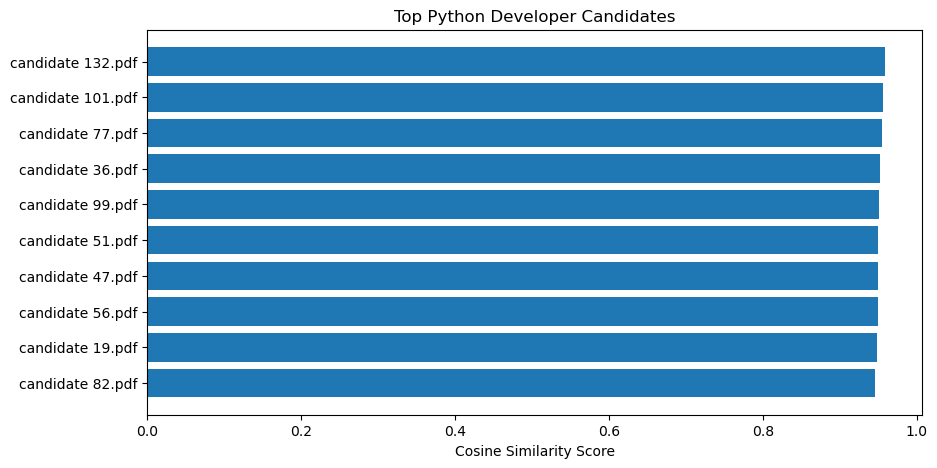

In [8]:
# Cell 8: Run everything and rank
resumes_dict = load_resumes(RESUME_FOLDER)
if not resumes_dict:
    print("❌ No extractable resumes found in folder!")
else:
    ranking = rank_resumes(job_description_text, resumes_dict, top_n=TOP_N)


In [9]:
# Cell 9: View cleaned resume text for debugging
def show_cleaned_resume(name, resumes_dict):
    if name not in resumes_dict:
        print("Resume not found.")
        return
    print(f"---- {name} ----")
    print(resumes_dict[name][:1500], "...")

# Example usage:
if resumes_dict:
    first_resume = list(resumes_dict.keys())[0]
    show_cleaned_resume(first_resume, resumes_dict)


---- candidate 1.pdf ----
summary skill experience education training certifications jessica claire montgomery st th floor experience software developer year experience python programming ibm cloud unix shell scripting extensive experience software development life cycle include requirement analysis object orient analysis design development testing documentation support good understanding oop concept multithreade socket programming experience agile waterfall methodology ability rapidly absorb new concept apply effectively innovative problem solve skill export trouble shooter effective work independently collaboratively team excellent communication writing skill interest network mathematic programming passionate learn new technology upgrade skill ibm cloud e markdown language python programming e jira c programming e terraform c programming e pthon scrapy module linux shell scripting e flask e github e pivotal tracker golang e agile development methodology e visual studio code e testing